# MS4
- Build a Feature Importance notebook discussing feature importance


In [ ]:
#load dataset
import gdown
import pandas as pd
import os

file_id = "1wVHHFxZJ8AWwwXeD2BQs545AKZfwmlHN"
training_datapath = "cleaned_full_data.pkl"

if not os.path.exists(training_datapath):
    print("Downloading data from Google Drive...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", training_datapath, quiet=False)

included_columns = ["CASE_STATUS", "RECEIVED_DATE", "DECISION_DATE", "EMPLOYER_STATE_PROVINCE", "EMPLOYER_CITY", "WORKSITE_STATE", "WORKSITE_CITY", "COUNTRY_OF_CITIZENSHIP", "EMPLOYER_NUM_EMPLOYEES"]
training_data = pd.read_pickle(training_datapath)[included_columns]

!pip install keras_tuner

Downloading...
From (original): https://drive.google.com/uc?id=1wVHHFxZJ8AWwwXeD2BQs545AKZfwmlHN
From (redirected): https://drive.google.com/uc?id=1wVHHFxZJ8AWwwXeD2BQs545AKZfwmlHN&confirm=t&uuid=15ead747-03af-4239-908b-6a124f3d0e0b
To: /content/cleaned_full_data.pkl
100%|██████████| 117M/117M [00:01<00:00, 63.2MB/s]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import keras_tuner as kt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [ ]:
def getDays(datetime_val):
    if type(datetime_val) != datetime:
        return datetime_val
    return datetime_val.days
training_data["CASE_STATUS_FLAG"] = training_data["CASE_STATUS"].apply(lambda x: 1 if "Certified" == x else 0)
training_data['CASE_APPROVAL_LENGTH'] = training_data['DECISION_DATE'] - training_data['RECEIVED_DATE']
training_data['CASE_APPROVAL_LENGTH'] = training_data['CASE_APPROVAL_LENGTH'].apply(getDays)
for col in training_data.select_dtypes(include=['datetime64']).columns:
    training_data[col] = training_data[col].astype('int64') // 10**9
training_data = training_data.dropna()

**Input and Output data**

In [ ]:
#data
X_Logistic_Regression = training_data.drop(columns=['CASE_STATUS_FLAG', 'CASE_STATUS'], axis=1)  #drop target and related column
X_Logistic_Regression['CASE_APPROVAL_LENGTH'] = X_Logistic_Regression['CASE_APPROVAL_LENGTH'].dt.days
y_Logistic_Regression = training_data['CASE_STATUS_FLAG']  #target variable

#handle categorical variables by encoding them
label_encoders = {}
for column in X_Logistic_Regression.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_Logistic_Regression[column] = le.fit_transform(X_Logistic_Regression[column].astype(str))
    label_encoders[column] = le

**Splitting Data**

In [ ]:
#split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_Logistic_Regression,
    y_Logistic_Regression,
    test_size=0.2,
    random_state=42,
    stratify=y_Logistic_Regression
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)
print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 62738
Validation samples: 20913
Testing samples: 20913


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()
    #tune the number of layers: 1 to 5
    for i in range(hp.Int('num_layers', 1, 5)):
        #tune the number of neurons: 32, 64, 128, 256
        units = hp.Choice(f'units_{i}', values=[32, 64, 128, 256])
        #tune the activation function: ReLU, Leaky ReLU, tanh
        activation = hp.Choice(f'activation_{i}', values=['relu', 'leaky_relu', 'tanh'])
        #add dense layer with activation
        if activation == 'leaky_relu':
            model.add(Dense(units, activation=None))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(Dense(units, activation=activation))
        #tune dropout rate: 0.2, 0.3, 0.5
        dropout_rate = hp.Choice(f'dropout_{i}', values=[0.2, 0.3, 0.5])
        model.add(Dropout(rate=dropout_rate))
    #output Layer
    model.add(Dense(1, activation='sigmoid'))
    #tune optimizer: Adam, RMSprop, SGD
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

    #tune learning rate
    if optimizer_choice == 'adam':
        learning_rate = hp.Float('adam_lr', 1e-4, 1e-2, sampling='log')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        learning_rate = hp.Float('rmsprop_lr', 1e-4, 1e-2, sampling='log')
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        learning_rate = hp.Float('sgd_lr', 1e-4, 1e-2, sampling='log')
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    #compile the Model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

**Extracting Best Model from Hyperparameter tuning**

In [ ]:
#initialize the Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='visa_prediction_tuning'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

early_stop_accuracy = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

#hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, early_stop_accuracy],
    verbose=1
)

#retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  Layer {i+1}:")
    print(f"    Units: {best_hps.get(f'units_{i}')}")
    print(f"    Activation: {best_hps.get(f'activation_{i}')}")
    print(f"    Dropout Rate: {best_hps.get(f'dropout_{i}')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
if best_hps.get('optimizer') == 'adam':
    print(f"Learning Rate: {best_hps.get('adam_lr')}")
elif best_hps.get('optimizer') == 'rmsprop':
    print(f"Learning Rate: {best_hps.get('rmsprop_lr')}")
else:
    print(f"Learning Rate: {best_hps.get('sgd_lr')}")

Trial 20 Complete [00h 07m 41s]
val_accuracy: 0.9722182154655457

Best val_accuracy So Far: 0.9797733426094055
Total elapsed time: 02h 30m 10s

Best Hyperparameters:
Number of Layers: 3
  Layer 1:
    Units: 32
    Activation: relu
    Dropout Rate: 0.3
  Layer 2:
    Units: 32
    Activation: leaky_relu
    Dropout Rate: 0.5
  Layer 3:
    Units: 256
    Activation: tanh
    Dropout Rate: 0.5
Optimizer: adam
Learning Rate: 0.0002775931598849941


In [ ]:
#build the Best Model
best_model = tuner.hypermodel.build(best_hps)
#train the Best Model
final_history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')

NameError: name 'tuner' is not defined

# Get Feature Importance info using shap


In [ ]:
import shap
# Create a SHAP explainer
explainer = shap.Explainer(best_model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

ExactExplainer explainer: 20914it [14:28, 23.86it/s]                           


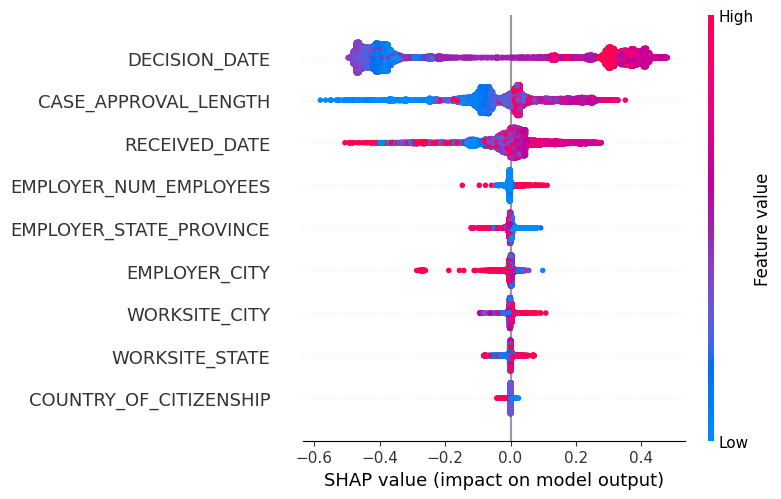

In [ ]:
# Visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names= X_Logistic_Regression.columns.tolist())

# Conclusions

The most important features to determining whether a visa is granted or not have to do with the date and length of the application. The most important is the date the case was decided: cases decided more recently were more likely to be granted. The second most important is the approval length: the longer the case take, the more likely the visa is to be granted. The third most important is the received date, though there is less of a pattern with this feature. Next in importance is the number of employees the employer already has, with more employees meaning a slightly greater chance of the visa being granted, but few employees having minimal effect. The next important featrures are the employer location, then worksite location. Finally, the origin country of the applicant is least important.